In [1]:
# Notebook for iterating on HDBSCAN with the full input dataset
# for ease of hyperparameter choice.

import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import skew, kurtosis, norm, mode
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import psutil
import shutil
import os
%matplotlib inline

In [2]:
hit_params = np.load('/datax/scratch/benjb/C23_L_full_13_params_array.npy', allow_pickle=True)
hit_dats = np.load('/datax/scratch/benjb/C23_L_full_13_params_dats.npy', allow_pickle=True)
print(hit_params.shape)
print(hit_dats.shape)

(1917903, 13)
(1917903, 2)


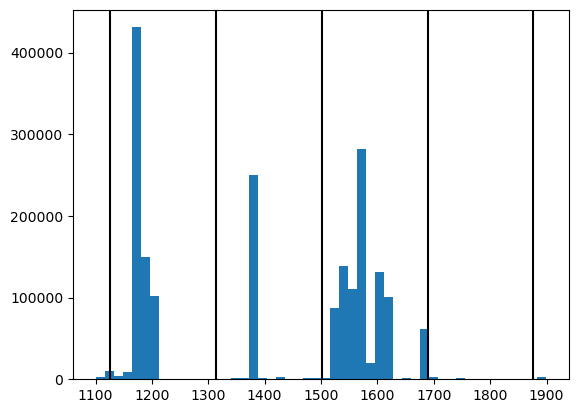

In [6]:
plt.hist(hit_params[:,0], bins=50)
plt.axvline(1126.4648451469839, color='k')
plt.axvline(1313.9648451469839, color='k')
plt.axvline(1501.4648451469839, color='k')
plt.axvline(1688.9648451469839, color='k')
plt.axvline(1876.4648423530161, color='k')
#plt.yscale('log')
plt.show()

In [45]:
def preprocess(data):

    freqs = data[:,0]
    drifts = data[:,1]
    snrs = data[:,2]
    skews = data[:,3]
    kurts = data[:,4]
    sarles = data[:,5]
    corrs = data[:,6]
    tbws = data[:,7]
    tskews = data[:,8]
    tstds = data[:,9]
    fstds = data[:,10]
    sigbws = data[:,11]
    reds = data[:,12]

    normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), n_quantiles=100000, 
                                   output_distribution='normal', subsample=100000)
    normal_drifts = normal_drifts.reshape(len(normal_drifts))

    data_arr = np.array([np.argsort(np.argsort(freqs))/len(freqs),
                        #0.1*(freqs-np.min(freqs))/np.max(freqs-np.min(freqs)), 
                        np.abs(normal_drifts)/np.max(np.abs(normal_drifts)), 
                        (np.log10(snrs)-np.min(np.log10(snrs)))/np.max(np.log10(snrs)-np.min(np.log10(snrs))), 
                        (skews-np.min(skews))/np.max((skews-np.min(skews))), 
                        (np.log10(kurts)-np.min(np.log10(kurts)))/np.max(np.log10(kurts)-np.min(np.log10(kurts))), 
                        sarles, 
                        corrs, 
                        (np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6)))/np.max(np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6))),
                        (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                        (np.log10(tstds)-np.min(np.log10(tstds))),
                        (np.log10(fstds)-np.min(np.log10(fstds))),
                        sigbws/np.max(sigbws),
                        (np.log10(reds)-np.min(np.log10(reds)))/(np.max(np.log10(reds))-np.min(np.log10(reds)))
                        ])  ### PRE-PROCESSED FOR HDBSCAN

    data_arr_unscaled = np.array([freqs, 
                        drifts, 
                        snrs, 
                        skews, 
                        kurts, 
                        sarles, 
                        corrs, 
                        tbws*1e6, # units of Hz
                        tskews,
                        tstds,
                        fstds,
                        sigbws*1e6, # units of Hz
                        reds
                        ])

    return np.transpose(data_arr), np.transpose(data_arr_unscaled)

def batch_hdbscan(batch_arr_scaled, nmincluster, nminsamples, eps):

    hdb = HDBSCAN(
        min_cluster_size=nmincluster, 
        min_samples=nminsamples, 
        cluster_selection_epsilon=eps, 
        #metric = 'haversine',
        leaf_size=40,
        n_jobs=10,
        cluster_selection_method='eom',
        store_centers='centroid')
    
    X = batch_arr_scaled
    hdb.fit(X)

    labels_list = hdb.labels_
    centroids = hdb.centroids_

    return labels_list, centroids

In [46]:
m81_params = np.load('/datax/scratch/benjb/C23_L_M81_injections/M81_retrieval_all_params.npy', allow_pickle=True)[0]
stg_idxs = np.load('/datax/scratch/benjb/C23_L_M81_injections/idxs_of_injections_in_dat.npy', allow_pickle=True)
dat = glob.glob('/datax/scratch/benjb/C23_L_M81_injections/*.dat')[0]
df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
table_freqs = df['Uncorrected_Frequency'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
table_drifts = df['Drift_Rate'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
table_snrs = df['SNR'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
m81_params_trimmed = m81_params[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
m81_reds = np.load('/datax/scratch/benjb/C23_L_M81_injections/M81_retrieval_rednesses.npy', allow_pickle=True)[0]
m81_reds = m81_reds[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
freqs = table_freqs[stg_idxs]
drifts = table_drifts[stg_idxs]
snrs = table_snrs[stg_idxs]
reds = m81_reds[stg_idxs]
stg_params_9 = m81_params_trimmed[stg_idxs]
stg_params = np.hstack([np.transpose([freqs, drifts, snrs]), stg_params_9, np.transpose([reds])])
print(stg_params.shape)

(100, 13)


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1237343/2062051969.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',


In [63]:
full_params = np.vstack((hit_params, stg_params)) # need to be preprocessed together for quantile transforms
full_params_scaled, full_params_unscaled = preprocess(full_params)

hit_params_scaled = full_params_scaled[:-100]
print(f'Size hit_params_scaled = {len(hit_params_scaled)}')
hit_params_unscaled = full_params_unscaled[:-100]
print(f'Size hit_params_unscaled = {len(hit_params_unscaled)}')
stg_params_scaled = full_params_scaled[-100:]
stg_params_unscaled = full_params_unscaled[-100:]

n_batches = len(hit_dats) // 3000
batch_size = len(hit_dats) // n_batches

print(f'Number of batches: {n_batches}')
print(f'Size of each batch: {batch_size} hits')

hit_batches_scaled = []
hit_batches_unscaled = []
dat_batches = []
idx_batches = []

# shuffle hits before batching
idxs = np.arange(len(hit_params_scaled))
np.random.shuffle(idxs) 
hit_params_scaled_shuffled = hit_params_scaled[idxs]
hit_params_unscaled_shuffled = hit_params_unscaled[idxs]

print('Batching ...')

# do the batching
for i in range(n_batches):

    if i != n_batches-1:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:(i+1)*batch_size]
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:(i+1)*batch_size]
    else:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:] # catch the last few entries in the final batch
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:]

    hit_batches_scaled.append(batch_scaled)
    hit_batches_unscaled.append(batch_unscaled)

Size hit_params_scaled = 1917903
Size hit_params_unscaled = 1917903
Number of batches: 639
Size of each batch: 3001 hits
Batching ...


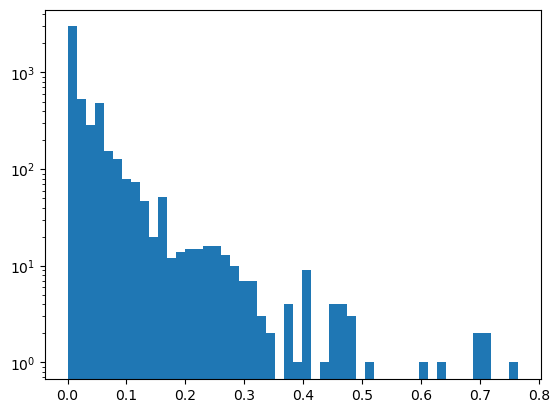

In [51]:
plt.hist(hit_batches_scaled[15][:,11], bins=50)
plt.yscale('log')
plt.show()

In [88]:
print('Running HDBSCAN on all batches ...')

# do the HDBSCANning
nmincluster = 4
nminsamples = 2
eps = 0.18

cluster_counts = []
largest_cluster_sizes = []

for i in range(len(hit_batches_scaled)):
    print('----------')
    bbb_scaled = np.vstack((hit_batches_scaled[i], stg_params_scaled))
    labels_list, centroids = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)
    non_anom_labels = np.array(list(
        set(np.unique(labels_list))-set(np.unique(np.concatenate((labels_list[-100:], [-1]))))
        ))
    mask = np.isin(labels_list[:-100], non_anom_labels)

    # track non-anomalous hits for later superclustering 
    truncated_labels_list = labels_list[:-100]
    non_anom_labels_list = truncated_labels_list[mask]
    print(f'Non-anomalous (RFI) hits: {len(non_anom_labels_list)}')
    print(f'Unique clusters: {len(np.unique(labels_list))}')
    print(f'Largest cluster share: {round(100*mode(labels_list)[1]/len(labels_list), 3)}%')

    cluster_counts.append(len(np.unique(labels_list)))
    largest_cluster_sizes.append(100*mode(labels_list)[1]/len(labels_list))

# We choose eps=0.18 because it strikes a good balance between low largest cluster share,
# low number of unique clusters, and similar counts of non-anomalous hits.

Running HDBSCAN on all batches ...
----------
Non-anomalous (RFI) hits: 1840
Unique clusters: 117
Largest cluster share: 38.407%
----------
Non-anomalous (RFI) hits: 0
Unique clusters: 3
Largest cluster share: 98.936%
----------
Non-anomalous (RFI) hits: 1809
Unique clusters: 110
Largest cluster share: 39.503%
----------
Non-anomalous (RFI) hits: 1829
Unique clusters: 123
Largest cluster share: 38.471%
----------
Non-anomalous (RFI) hits: 1744
Unique clusters: 122
Largest cluster share: 41.47%
----------
Non-anomalous (RFI) hits: 9
Unique clusters: 5
Largest cluster share: 98.678%
----------
Non-anomalous (RFI) hits: 1892
Unique clusters: 111
Largest cluster share: 36.859%
----------
Non-anomalous (RFI) hits: 1828
Unique clusters: 127
Largest cluster share: 38.826%
----------
Non-anomalous (RFI) hits: 4
Unique clusters: 3
Largest cluster share: 99.839%
----------
Non-anomalous (RFI) hits: 1721
Unique clusters: 110
Largest cluster share: 42.373%
----------
Non-anomalous (RFI) hits: 1748

KeyboardInterrupt: 

80.9076682316119


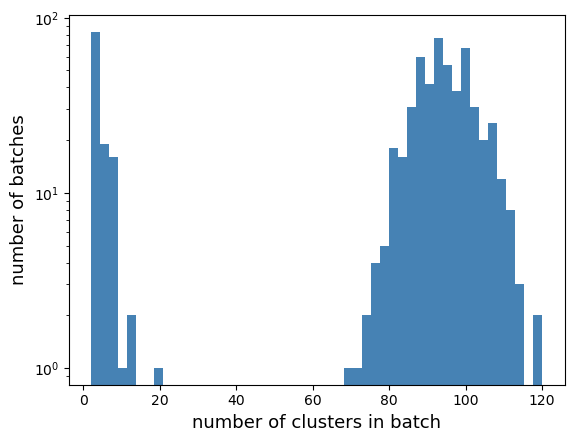

In [85]:
print(100*len(np.where(np.array(cluster_counts) > 40)[0])/len(cluster_counts))
plt.hist(cluster_counts, bins=50, color='steelblue')
plt.yscale('log')
plt.xlabel('number of clusters in batch', size=13)
plt.ylabel('number of batches', size=13)
plt.savefig('C23_L_hyperparameter_selection_cluster_counts_3k_4_2_0.19_80.9.pdf', bbox_inches='tight')
plt.show()

80.9076682316119


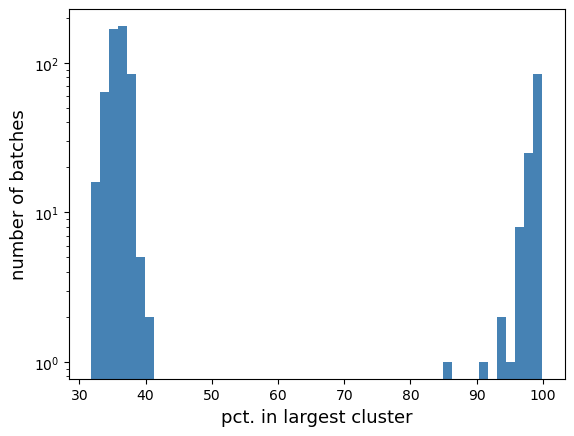

In [84]:
print(100*len(np.where(np.array(cluster_counts) > 40)[0])/len(cluster_counts))
plt.hist(largest_cluster_sizes, bins=50, color='steelblue')
plt.yscale('log')
plt.xlabel('pct. in largest cluster', size=13)
plt.ylabel('number of batches', size=13)
#plt.savefig('C23_L_hyperparameter_selection_cluster_counts_3k_4_2_0.18_80.9.pdf', bbox_inches='tight')
plt.show()